<a href="https://colab.research.google.com/github/WyattRoss/csci4170/blob/main/Homework5_(TASK_1%262).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import glob
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torchvision.utils import make_grid, save_image

In [26]:
def load_dataset(folder_path, target_size=(224, 224), normalize=True, class_name="card_name"):
    """
    Load images from folder structure into a pandas DataFrame for CNN training.

    Parameters:
    - folder_path: Path to the folder containing image subdirectories
    - target_size: Tuple of (height, width) to resize images to
    - normalize: Whether to normalize pixel values to [0, 1] range

    Returns:
    - DataFrame with columns: 'image_path', 'image_array', 'label', 'card_name'
    """

    data_list = []
    cards_path = Path(folder_path)

    # Verify the cards folder exists
    if not cards_path.exists():
        raise FileNotFoundError(f"folder not found: {folder_path}")

    # Get all subdirectories (card folders)
    card_folders = [f for f in cards_path.iterdir() if f.is_dir()]

    print(f"Found {len(card_folders)} folders")

    # Create label encoding
    card_names = sorted([folder.name for folder in card_folders])
    label_to_index = {name: idx for idx, name in enumerate(card_names)}

    print("Processing:")
    for card_folder in sorted(card_folders):
        card_name = card_folder.name
        label = label_to_index[card_name]

        # Find all jpg images in this card folder
        image_files = list(card_folder.glob("*.jpg")) + list(card_folder.glob("*.JPG"))

        print(f"  {card_name}: {len(image_files)} images")

        for image_file in image_files:
            try:
                # Load and preprocess image
                img = Image.open(image_file)

                # Convert to RGB if needed (handles grayscale or RGBA)
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Resize image
                img = img.resize(target_size, Image.Resampling.LANCZOS)

                # Convert to numpy array
                img_array = np.array(img)

                # Normalize if requested
                if normalize:
                    img_array = img_array.astype(np.float32) / 255.0

                # Add to data list
                data_list.append({
                    'image_path': str(image_file),
                    'image_array': img_array,
                    'label': label,
                    class_name: card_name
                })

            except Exception as e:
                print(f"    Error loading {image_file}: {e}")
                continue

    # Create DataFrame
    df = pd.DataFrame(data_list)

    print(f"\nDataset loaded successfully!")
    print(f"Total images: {len(df)}")
    print(f"Unique classes: {df[class_name].nunique()}")
    print(f"Image shape: {df['image_array'].iloc[0].shape}")

    return df, card_names

In [4]:
class CardDataset(Dataset):
    """Custom dataset for card images."""

    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.transform is None:
            raise ValueError("Transform must be provided to CardDataset")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image array (should be uint8 [0-255])
        img_array = self.df.iloc[idx]['image_array']

        # Ensure the array is uint8
        if img_array.dtype != np.uint8:
            if img_array.max() <= 1.0:  # If normalized, denormalize
                img_array = (img_array * 255).astype(np.uint8)
            else:
                img_array = img_array.astype(np.uint8)

        # Convert to PIL Image
        image = Image.fromarray(img_array)
        label = self.df.iloc[idx]['label']

        # Apply transforms (this should always convert to tensor)
        image = self.transform(image)

        # Double-check that we have a tensor
        if not isinstance(image, torch.Tensor):
            raise TypeError(f"Transform did not return tensor, got {type(image)}")

        return image, label

In [5]:
def get_transforms():
    """Define data augmentation transforms."""

    train_transform = transforms.Compose([
        transforms.RandomRotation(15),  # Cards can be slightly rotated
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

In [6]:
def create_data_loaders(df, batch_size=32, val_size=0.15, random_state=42, use_augmentation=False):
    """Create train and validation data loaders."""

    # Split the data
    train_df, val_df = train_test_split(
        df, test_size=val_size, stratify=df['label'], random_state=random_state
    )

    print(f"\nData split:")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Samples per class (train): {len(train_df) / df['card_name'].nunique():.1f}")

    # Get transforms based on whether we want augmentation
    if use_augmentation:
        train_transform, val_transform = get_transforms()
        print("Using data augmentation for training")
    else:
        # Use the same simple transform for both train and val
        simple_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        train_transform = simple_transform
        val_transform = simple_transform
        print("Using identical transforms for train and validation (no augmentation)")

    # Create datasets
    train_dataset = CardDataset(train_df, transform=train_transform)
    val_dataset = CardDataset(val_df, transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, train_df, val_df

# Convolutional Base
The moderately high number of classes, and the fact that there is higher variation within a class than between classes suggests that we'll need at least a few convolutional layers (too few would struggle with subtle differences like hearts vs. spades or even number cards vs face cards).

# Final decision:
- 4 Convolutional layers
- 3 Pooling layers

In [7]:
class CardCNN(nn.Module):
    """
    Minimal CNN for card classification with 4 conv layers and 3 pooling layers.
    Designed for limited training data (~90-100 samples per class).
    """

    def __init__(self, num_classes=53, dropout_rate=0.4):
        super(CardCNN, self).__init__()

        # First conv block - capture edges and basic shapes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 224x224 -> 112x112

        # Second conv block - detect patterns and symbols
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112x112 -> 56x56

        # Third conv block - combine features
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth conv block - complex pattern recognition
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56x56 -> 28x28

        # Global average pooling instead of flatten to reduce parameters
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # 28x28 -> 1x1

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Final classifier
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Third conv block (no pooling)
        x = F.relu(self.bn3(self.conv3(x)))

        # Fourth conv block with final pooling
        x = self.pool3(F.relu(self.bn4(self.conv4(x))))

        # Global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 128)

        # Dropout and classification
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [8]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, device='cuda'):
    """Train the CNN model."""

    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Training history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10

    print(f"\nStarting training on {device}...")
    print("=" * 60)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Store history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_card_model.pth')
        else:
            patience_counter += 1

        # Print progress
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:5.2f}% | '
                  f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:5.2f}%')

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break

        scheduler.step()

    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
    return train_losses, val_losses, train_accs, val_accs

In [9]:
def evaluate_model(model, val_loader, card_names, device='cuda'):
    """Evaluate the model and show detailed results."""

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nFinal Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Find unique classes present in validation set
    unique_labels = sorted(list(set(all_labels)))
    print(f"Classes present in validation set: {len(unique_labels)} out of {len(card_names)}")

    # Show just the first 10 classes that are actually present
    selected_labels = unique_labels[:10]
    target_names = [card_names[i] for i in selected_labels]

    # Filter predictions and labels to only include these classes
    mask = np.isin(all_labels, selected_labels)
    filtered_labels = np.array(all_labels)[mask]
    filtered_preds = np.array(all_preds)[mask]

    print(f"\nClassification Report (first 10 classes present in validation):")
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=selected_labels,
        target_names=target_names,
        zero_division=0
    ))

    # Show per-class accuracy for insight
    print(f"\nPer-class accuracy (top 10 by frequency):")
    from collections import Counter
    label_counts = Counter(all_labels)
    most_common_labels = [label for label, count in label_counts.most_common(10)]

    for label in most_common_labels:
        mask = np.array(all_labels) == label
        if mask.sum() > 0:
            class_acc = accuracy_score(
                np.array(all_labels)[mask],
                np.array(all_preds)[mask]
            )
            print(f"  {card_names[label]}: {class_acc:.3f} ({mask.sum()} samples)")

    return accuracy, all_preds, all_labels

In [10]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation metrics."""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy', linewidth=2)
    ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [11]:
CARDS_FOLDER = "drive/MyDrive/cards"  # Path to your cards folder
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("CARD CLASSIFICATION CNN TRAINING")
print(f"Device: {DEVICE}")

# Load data
print("\n1. Loading card dataset...")
df, card_names = load_dataset(CARDS_FOLDER)
# Create data loaders
print("\n2. Creating data loaders...")
train_loader, val_loader, train_df, val_df = create_data_loaders(
    df, batch_size=BATCH_SIZE, val_size=0.15
)

CARD CLASSIFICATION CNN TRAINING
Device: cuda

1. Loading card dataset...
Found 53 card folders
Processing cards:
  ace of clubs: 120 images
  ace of diamonds: 129 images
  ace of hearts: 171 images
  ace of spades: 181 images
  eight of clubs: 138 images
  eight of diamonds: 159 images
  eight of hearts: 152 images
  eight of spades: 135 images
  five of clubs: 150 images
  five of diamonds: 138 images
  five of hearts: 136 images
  five of spades: 158 images
  four of clubs: 157 images
  four of diamonds: 114 images
  four of hearts: 154 images
  four of spades: 140 images
  jack of clubs: 171 images
  jack of diamonds: 160 images
  jack of hearts: 168 images
  jack of spades: 172 images
  joker: 115 images
  king of clubs: 128 images
  king of diamonds: 135 images
  king of hearts: 125 images
  king of spades: 151 images
  nine of clubs: 124 images
  nine of diamonds: 129 images
  nine of hearts: 133 images
  nine of spades: 154 images
  queen of clubs: 161 images
  queen of diamond

In [18]:
# Create model
print("\n3. Creating model...")
model = CardCNN(num_classes=len(card_names), dropout_rate=0.4)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")

# Train model
print("\n4. Training model...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)


3. Creating model...
Model created with 249,909 total parameters
Trainable parameters: 249,909

4. Training model...

Starting training on cuda...
Epoch [ 1/50] | Train Loss: 3.6090 | Train Acc:  6.47% | Val Loss: 3.3580 | Val Acc:  8.22%
Epoch [ 6/50] | Train Loss: 2.8361 | Train Acc: 16.59% | Val Loss: 2.7325 | Val Acc: 22.47%
Epoch [11/50] | Train Loss: 2.4708 | Train Acc: 25.77% | Val Loss: 2.4416 | Val Acc: 30.42%
Epoch [16/50] | Train Loss: 2.1770 | Train Acc: 32.25% | Val Loss: 2.1147 | Val Acc: 36.36%
Epoch [21/50] | Train Loss: 2.0264 | Train Acc: 36.42% | Val Loss: 1.9448 | Val Acc: 44.14%
Epoch [26/50] | Train Loss: 1.8874 | Train Acc: 42.72% | Val Loss: 1.8820 | Val Acc: 48.51%
Epoch [31/50] | Train Loss: 1.6974 | Train Acc: 49.14% | Val Loss: 1.6079 | Val Acc: 59.79%
Epoch [36/50] | Train Loss: 1.5821 | Train Acc: 52.79% | Val Loss: 1.4977 | Val Acc: 62.50%
Epoch [41/50] | Train Loss: 1.5002 | Train Acc: 55.46% | Val Loss: 1.4502 | Val Acc: 62.41%
Epoch [46/50] | Train Lo


5. Loading best model and evaluating...

Final Validation Accuracy: 0.7002 (70.02%)
Classes present in validation set: 53 out of 53

Classification Report (first 10 classes present in validation):
                   precision    recall  f1-score   support

     ace of clubs       1.00      0.83      0.91        18
  ace of diamonds       1.00      0.74      0.85        19
    ace of hearts       0.95      0.73      0.83        26
    ace of spades       0.77      0.85      0.81        27
   eight of clubs       1.00      0.38      0.55        21
eight of diamonds       0.90      0.75      0.82        24
  eight of hearts       1.00      0.65      0.79        23
  eight of spades       1.00      0.40      0.57        20
    five of clubs       0.93      0.61      0.74        23
 five of diamonds       0.94      0.76      0.84        21

        micro avg       0.93      0.68      0.78       222
        macro avg       0.95      0.67      0.77       222
     weighted avg       0.94     

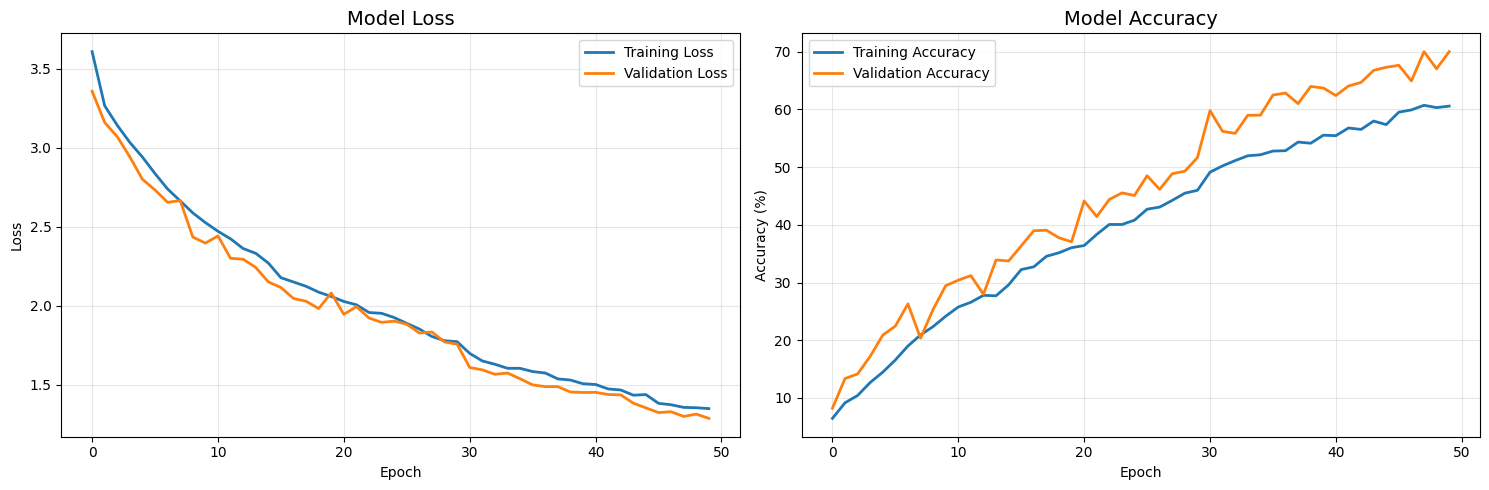


TRAINING COMPLETED!
Final validation accuracy: 70.02%
Best model saved as 'best_card_model.pth'


In [19]:
# Load best model and evaluate
print("\n5. Loading best model and evaluating...")
model.load_state_dict(torch.load('best_card_model.pth'))
accuracy, preds, labels = evaluate_model(model, val_loader, card_names, DEVICE)

# Plot results
print("\n6. Plotting training history...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)


print("\nTRAINING COMPLETED!")
print(f"Final validation accuracy: {accuracy*100:.2f}%")
print("Best model saved as 'best_card_model.pth'")

# Transfer Learning
I decided to use MobileNet because we're working with relatively limited data.

As the results will show, the transfer learning approach converged after fewer epochs, converged to a higher validation accuracy, and converged more monotonically than the manually implemented CNN.

This is because the pretrained nature of MobileNet gives transfer learning based models built around it a head start in feature recognition.

In [21]:
class MobileNetCard(nn.Module):
    """MobileNetV2 with custom classifier for card classification."""

    def __init__(self, num_classes=53, dropout_rate=0.5, freeze_features=True):
        super(MobileNetCard, self).__init__()

        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(pretrained=True)

        # Freeze feature extraction layers if requested
        if freeze_features:
            # Freeze early layers, fine-tune last few blocks
            for i, param in enumerate(self.mobilenet.features.parameters()):
                if i < len(list(self.mobilenet.features.parameters())) * 0.7:  # Freeze first 70%
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            print("Frozen first 70% of MobileNet feature layers")
        else:
            print("All MobileNet layers will be fine-tuned")

        # Replace the classifier
        # MobileNetV2 has 1280 features before the final classifier
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.mobilenet(x)

In [22]:
# Create model
print("\n3. Creating model...")
model = MobileNetCard(num_classes=len(card_names), dropout_rate=0.4)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")

# Train model
print("\n4. Training model...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)


3. Creating model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


Frozen first 70% of MobileNet feature layers
Model created with 2,906,933 total parameters
Trainable parameters: 2,426,805

4. Training model...

Starting training on cuda...
Epoch [ 1/50] | Train Loss: 2.4727 | Train Acc: 26.77% | Val Loss: 1.4403 | Val Acc: 52.19%
Epoch [ 6/50] | Train Loss: 0.4518 | Train Acc: 86.11% | Val Loss: 0.5512 | Val Acc: 84.35%
Epoch [11/50] | Train Loss: 0.2466 | Train Acc: 92.79% | Val Loss: 0.5561 | Val Acc: 85.84%
Epoch [16/50] | Train Loss: 0.1064 | Train Acc: 96.77% | Val Loss: 0.4644 | Val Acc: 89.77%
Epoch [21/50] | Train Loss: 0.0553 | Train Acc: 98.21% | Val Loss: 0.4897 | Val Acc: 89.95%
Epoch [26/50] | Train Loss: 0.0460 | Train Acc: 98.61% | Val Loss: 0.4788 | Val Acc: 89.95%

Early stopping at epoch 29

Training completed! Best validation accuracy: 91.52%



5. Loading best model and evaluating...

Final Validation Accuracy: 0.9152 (91.52%)
Classes present in validation set: 53 out of 53

Classification Report (first 10 classes present in validation):
                   precision    recall  f1-score   support

     ace of clubs       1.00      0.94      0.97        18
  ace of diamonds       1.00      0.95      0.97        19
    ace of hearts       0.93      0.96      0.94        26
    ace of spades       0.96      0.93      0.94        27
   eight of clubs       1.00      0.81      0.89        21
eight of diamonds       1.00      0.96      0.98        24
  eight of hearts       0.96      0.96      0.96        23
  eight of spades       1.00      0.85      0.92        20
    five of clubs       1.00      0.91      0.95        23
 five of diamonds       1.00      0.95      0.98        21

        micro avg       0.98      0.92      0.95       222
        macro avg       0.98      0.92      0.95       222
     weighted avg       0.98     

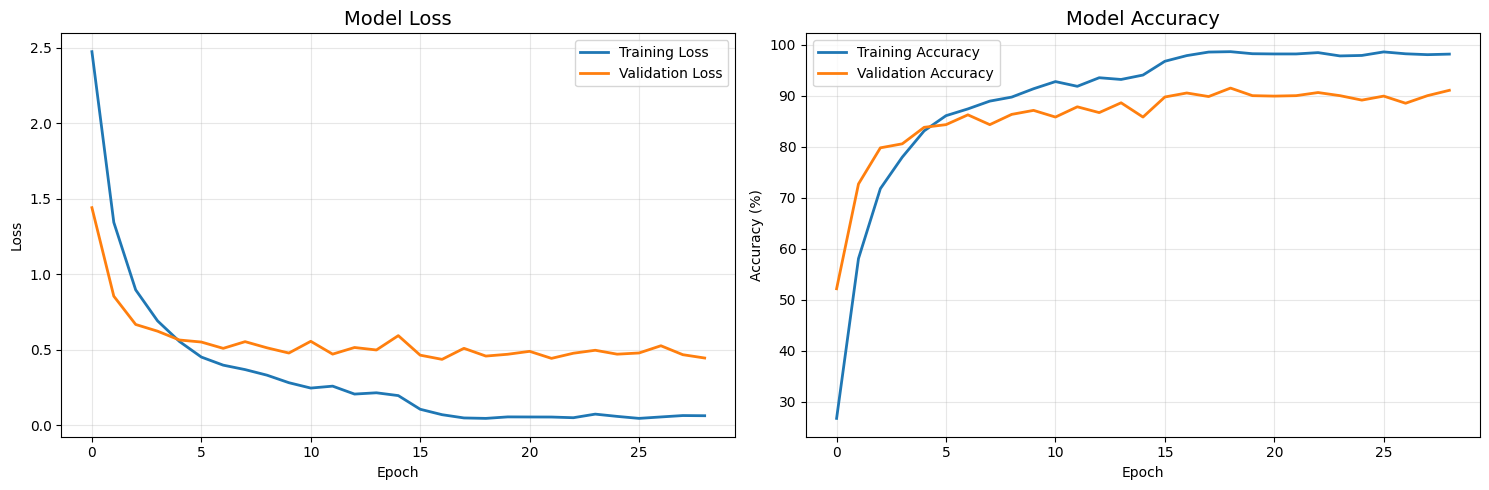


TRAINING COMPLETED!
Final validation accuracy: 91.52%
Best model saved as 'best_card_model.pth'


In [23]:
# Load best model and evaluate
print("\n5. Loading best model and evaluating...")
model.load_state_dict(torch.load('best_card_model.pth'))
accuracy, preds, labels = evaluate_model(model, val_loader, card_names, DEVICE)

# Plot results
print("\n6. Plotting training history...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)


print("\nTRAINING COMPLETED!")
print(f"Final validation accuracy: {accuracy*100:.2f}%")
print("Best model saved as 'best_card_model.pth'")

# Augmenting Data

The results show that adding augmentations to the training data actively made the model less effective at learning. My assumption is that this has something to do with the size of the training data, but I'm not completely sure.

In [12]:
# Load data
print("\n1. Loading card dataset...")
df, card_names = load_dataset(CARDS_FOLDER)
# Create data loaders
print("\n2. Creating data loaders...")
train_loader, val_loader, train_df, val_df = create_data_loaders(
    df, batch_size=BATCH_SIZE, val_size=0.15, use_augmentation=True
)


1. Loading card dataset...
Found 53 card folders
Processing cards:
  ace of clubs: 120 images
  ace of diamonds: 129 images
  ace of hearts: 171 images
  ace of spades: 181 images
  eight of clubs: 138 images
  eight of diamonds: 159 images
  eight of hearts: 152 images
  eight of spades: 135 images
  five of clubs: 150 images
  five of diamonds: 138 images
  five of hearts: 136 images
  five of spades: 158 images
  four of clubs: 157 images
  four of diamonds: 114 images
  four of hearts: 154 images
  four of spades: 140 images
  jack of clubs: 171 images
  jack of diamonds: 160 images
  jack of hearts: 168 images
  jack of spades: 172 images
  joker: 115 images
  king of clubs: 128 images
  king of diamonds: 135 images
  king of hearts: 125 images
  king of spades: 151 images
  nine of clubs: 124 images
  nine of diamonds: 129 images
  nine of hearts: 133 images
  nine of spades: 154 images
  queen of clubs: 161 images
  queen of diamonds: 163 images
  queen of hearts: 139 images
  

In [13]:
# Create model
print("\n3. Creating model...")
model = CardCNN(num_classes=len(card_names), dropout_rate=0.4)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")

# Train model
print("\n4. Training model...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)


3. Creating model...
Model created with 249,909 total parameters
Trainable parameters: 249,909

4. Training model...

Starting training on cuda...
Epoch [ 1/50] | Train Loss: 3.6660 | Train Acc:  4.95% | Val Loss: 3.3015 | Val Acc:  8.92%
Epoch [ 6/50] | Train Loss: 2.9867 | Train Acc: 12.65% | Val Loss: 2.8732 | Val Acc: 16.96%
Epoch [11/50] | Train Loss: 2.7262 | Train Acc: 19.55% | Val Loss: 2.5861 | Val Acc: 23.60%
Epoch [16/50] | Train Loss: 2.4643 | Train Acc: 25.35% | Val Loss: 2.3067 | Val Acc: 27.71%
Epoch [21/50] | Train Loss: 2.3397 | Train Acc: 27.38% | Val Loss: 2.2040 | Val Acc: 27.01%
Epoch [26/50] | Train Loss: 2.2804 | Train Acc: 28.30% | Val Loss: 2.0824 | Val Acc: 32.52%
Epoch [31/50] | Train Loss: 2.1654 | Train Acc: 31.91% | Val Loss: 1.9784 | Val Acc: 37.15%
Epoch [36/50] | Train Loss: 2.1074 | Train Acc: 32.87% | Val Loss: 1.9392 | Val Acc: 38.11%
Epoch [41/50] | Train Loss: 2.0932 | Train Acc: 32.93% | Val Loss: 1.9024 | Val Acc: 40.30%
Epoch [46/50] | Train Lo


5. Loading best model and evaluating...

Final Validation Accuracy: 0.4502 (45.02%)
Classes present in validation set: 53 out of 53

Classification Report (first 10 classes present in validation):
                   precision    recall  f1-score   support

     ace of clubs       0.81      0.72      0.76        18
  ace of diamonds       0.92      0.58      0.71        19
    ace of hearts       1.00      0.69      0.82        26
    ace of spades       0.83      0.93      0.88        27
   eight of clubs       0.00      0.00      0.00        21
eight of diamonds       0.69      0.46      0.55        24
  eight of hearts       1.00      0.17      0.30        23
  eight of spades       1.00      0.10      0.18        20
    five of clubs       0.93      0.61      0.74        23
 five of diamonds       1.00      0.57      0.73        21

        micro avg       0.88      0.50      0.63       222
        macro avg       0.82      0.48      0.57       222
     weighted avg       0.82     

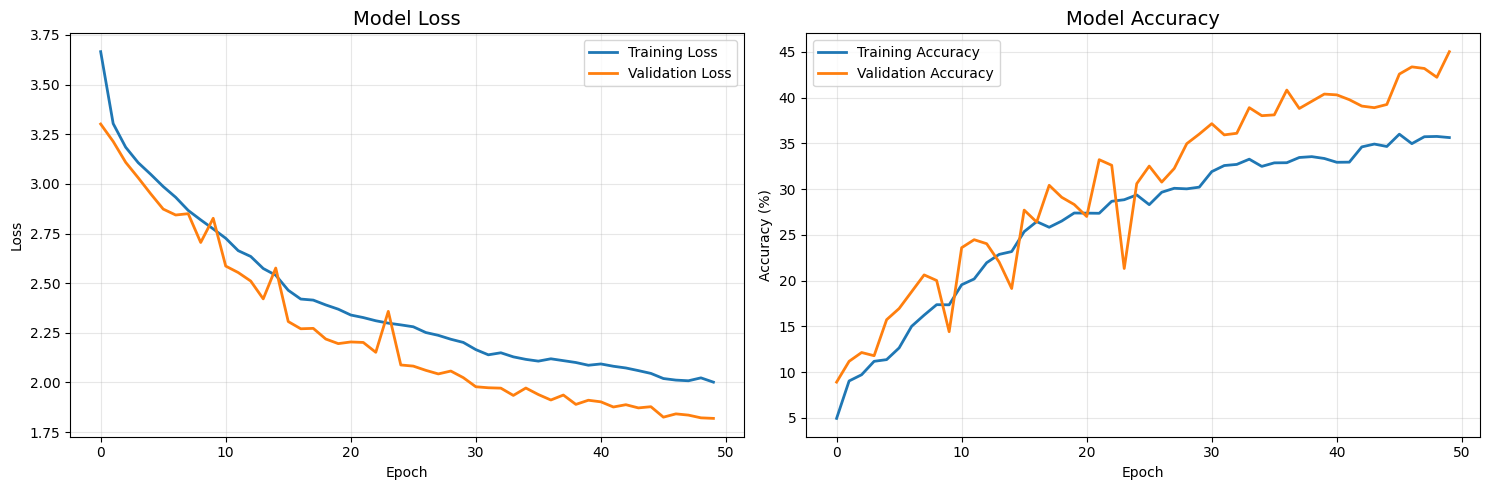


TRAINING COMPLETED!
Final validation accuracy: 45.02%
Best model saved as 'best_card_model.pth'


In [14]:
# Load best model and evaluate
print("\n5. Loading best model and evaluating...")
model.load_state_dict(torch.load('best_card_model.pth'))
accuracy, preds, labels = evaluate_model(model, val_loader, card_names, DEVICE)

# Plot results
print("\n6. Plotting training history...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)


print("\nTRAINING COMPLETED!")
print(f"Final validation accuracy: {accuracy*100:.2f}%")
print("Best model saved as 'best_card_model.pth'")

# Task 2: Image Generation

## VAEs:
The results for the VAE were not super impressive, the reconstructions look bad and the new samples are incoherent. Not sure why, but I don't have time to fix.

In [15]:
class ChessVAE(nn.Module):
    """
    Variational Autoencoder for chess piece generation.
    Designed for 64x64 RGB images.
    """

    def __init__(self, input_channels=3, latent_dim=128, image_size=64):
        super(ChessVAE, self).__init__()

        self.latent_dim = latent_dim
        self.image_size = image_size
        self.input_channels = input_channels

        # Calculate dimensions after convolutions
        # 64 -> 32 -> 16 -> 8 -> 4 (after 4 conv layers with stride 2)
        self.conv_output_size = 4
        self.conv_output_channels = 512
        self.flattened_size = self.conv_output_channels * self.conv_output_size * self.conv_output_size

        # ================== ENCODER ==================
        self.encoder = nn.Sequential(
            # 64x64x3 -> 32x32x64
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 32x32x64 -> 16x16x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 16x16x128 -> 8x8x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 8x8x256 -> 4x4x512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Latent space layers
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # ================== DECODER ==================
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            # 4x4x512 -> 8x8x256
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 8x8x256 -> 16x16x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 16x16x128 -> 32x32x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 32x32x64 -> 64x64x3
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def encode(self, x):
        """Encode input to latent distribution parameters."""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for sampling from latent distribution."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        """Decode latent vector to image."""
        h = self.fc_decode(z)
        h = h.view(h.size(0), self.conv_output_channels, self.conv_output_size, self.conv_output_size)
        return self.decoder(h)

    def forward(self, x):
        """Full forward pass through VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def sample(self, num_samples, device):
        """Sample new images from the learned distribution."""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
            return samples

In [47]:
class ChessDataset(Dataset):
    """
    Unified dataset for chess piece images that works with both VAE and GAN.

    Args:
        dataframe: DataFrame with chess piece data
        transform: Image transforms to apply
        return_labels: If True, returns (image, label). If False, returns image only.
    """

    def __init__(self, dataframe, transform=None, return_labels=True):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.return_labels = return_labels

        if self.transform is None:
            raise ValueError("Transform must be provided to ChessDataset")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image array
        img_array = self.df.iloc[idx]['image_array']

        # Ensure the array is uint8
        if img_array.dtype != np.uint8:
            if img_array.max() <= 1.0:
                img_array = (img_array * 255).astype(np.uint8)
            else:
                img_array = img_array.astype(np.uint8)

        # Convert to PIL Image
        image = Image.fromarray(img_array)

        # Apply transforms
        image = self.transform(image)

        # Return based on what the model needs
        if self.return_labels:
            # For VAE: return (image, label)
            label = self.df.iloc[idx]['label']
            return image, label
        else:
            # For GAN: return image only
            return image

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction Loss + KL Divergence Loss

    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight for KL divergence (β-VAE)
    """

    # Reconstruction loss (Binary Cross Entropy)
    # Since we're using Sigmoid output, BCE is appropriate
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence loss
    # KL(q(z|x) || p(z)) where p(z) = N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

In [17]:
def get_vae_transforms(image_size=64):
    """Define transforms for VAE training."""

    # For VAE, we typically use simpler transforms
    # Heavy augmentation can hurt reconstruction quality
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),  # Converts to [0, 1] range
        # Note: No normalization to ImageNet stats since we want [0,1] for Sigmoid output
    ])

    return transform

def create_vae_data_loaders(df, batch_size=64, val_size=0.15, image_size=64, random_state=42):
    """Create data loaders for VAE training."""

    # Split the data
    train_df, val_df = train_test_split(
        df, test_size=val_size, stratify=df['label'], random_state=random_state
    )

    print(f"\nVAE Data split:")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Samples per piece (train): {len(train_df) / df['piece_name'].nunique():.1f}")

    # Get transforms
    transform = get_vae_transforms(image_size)

    # Create datasets
    train_dataset = ChessDataset(train_df, transform=transform)
    val_dataset = ChessDataset(val_df, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, train_df, val_df

In [19]:
def plot_vae_training_history(train_losses, val_losses, train_recon, train_kl, val_recon, val_kl):
    """Plot VAE training metrics."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total loss
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_title('Total VAE Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Reconstruction loss
    ax2.plot(train_recon, label='Training Reconstruction', linewidth=2, color='orange')
    ax2.plot(val_recon, label='Validation Reconstruction', linewidth=2, color='red')
    ax2.set_title('Reconstruction Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # KL divergence loss
    ax3.plot(train_kl, label='Training KL', linewidth=2, color='green')
    ax3.plot(val_kl, label='Validation KL', linewidth=2, color='purple')
    ax3.set_title('KL Divergence Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Loss components comparison
    epochs = range(len(train_losses))
    ax4.plot(epochs, train_recon, label='Reconstruction', linewidth=2)
    ax4.plot(epochs, train_kl, label='KL Divergence', linewidth=2)
    ax4.set_title('Training Loss Components')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, data_loader, device, num_samples=8):
    """Visualize original vs reconstructed images."""

    model.eval()
    with torch.no_grad():
        # Get a batch of data
        data, _ = next(iter(data_loader))
        data = data[:num_samples].to(device)

        # Get reconstructions
        recon_data, _, _ = model(data)

        # Combine original and reconstructed
        comparison = torch.cat([data, recon_data])

        # Create grid
        grid = make_grid(comparison, nrow=num_samples, padding=2, normalize=False)

        # Plot
        plt.figure(figsize=(15, 6))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title('Original (top) vs Reconstructed (bottom)')
        plt.axis('off')
        plt.show()

In [18]:
def train_vae(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-3, beta=1.0, device='cuda'):
    """Train the VAE model."""

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    # Training history
    train_losses, val_losses = [], []
    train_recon_losses, train_kl_losses = [], []
    val_recon_losses, val_kl_losses = [], []

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    print(f"\nStarting VAE training on {device}...")
    print(f"Beta (KL weight): {beta}")
    print("=" * 70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_recon = 0.0
        train_kl = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            loss, recon_loss, kl_loss = vae_loss_function(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_recon += recon_loss.item()
            train_kl += kl_loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_recon = 0.0
        val_kl = 0.0

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)

                loss, recon_loss, kl_loss = vae_loss_function(recon_batch, data, mu, logvar, beta)

                val_loss += loss.item()
                val_recon += recon_loss.item()
                val_kl += kl_loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_train_recon = train_recon / len(train_loader.dataset)
        avg_train_kl = train_kl / len(train_loader.dataset)
        avg_val_recon = val_recon / len(val_loader.dataset)
        avg_val_kl = val_kl / len(val_loader.dataset)

        # Store history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_recon_losses.append(avg_train_recon)
        train_kl_losses.append(avg_train_kl)
        val_recon_losses.append(avg_val_recon)
        val_kl_losses.append(avg_val_kl)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_chess_vae.pth')
        else:
            patience_counter += 1

        # Print progress
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.1f} | Val Loss: {avg_val_loss:.1f} | '
                  f'Recon: {avg_val_recon:.1f} | KL: {avg_val_kl:.1f}')

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break

        scheduler.step()

    print(f"\nVAE training completed! Best validation loss: {best_val_loss:.1f}")
    return train_losses, val_losses, train_recon_losses, train_kl_losses, val_recon_losses, val_kl_losses

In [34]:
def generate_new_samples(model, device, num_samples=16):
    """Generate new chess piece samples."""

    model.eval()
    with torch.no_grad():
        samples = model.sample(num_samples, device)

        # Create grid
        grid = make_grid(samples, nrow=4, padding=2, normalize=False)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title('Generated Chess Pieces')
        plt.axis('off')
        plt.show()

        return samples

In [27]:
CHESS_FOLDER = "drive/MyDrive/Chess"  # Path to your chess pieces folder
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
LATENT_DIM = 128
IMAGE_SIZE = 64
BETA = 1.0  # β-VAE parameter
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Beta: {BETA}")

# Step 1: Load data
print("\n1. Loading chess dataset...")
df, piece_names = load_dataset(CHESS_FOLDER, target_size=(IMAGE_SIZE, IMAGE_SIZE), class_name="piece_name")

# Step 2: Create data loaders
print("\n2. Creating VAE data loaders...")
train_loader, val_loader, train_df, val_df = create_vae_data_loaders(
  df, batch_size=BATCH_SIZE, val_size=0.15, image_size=IMAGE_SIZE
)

Device: cuda
Image size: 64x64
Latent dimension: 128
Beta: 1.0

1. Loading chess dataset...
Found 6 folders
Processing:
  Bishop: 73 images
  King: 61 images
  Knight: 95 images
  Pawn: 88 images
  Queen: 68 images
  Rook: 90 images

Dataset loaded successfully!
Total images: 475
Unique classes: 6
Image shape: (64, 64, 3)

2. Creating VAE data loaders...

VAE Data split:
Training samples: 403
Validation samples: 72
Samples per piece (train): 67.2


In [30]:
# Step 3: Create model
print("\n3. Creating VAE model...")
model = ChessVAE(input_channels=3, latent_dim=LATENT_DIM, image_size=IMAGE_SIZE)

total_params = sum(p.numel() for p in model.parameters())
print(f"VAE model created with {total_params:,} parameters")

# Step 4: Train model
print("\n4. Training VAE...")
train_losses, val_losses, train_recon, train_kl, val_recon, val_kl = train_vae(
  model, train_loader, val_loader,
  num_epochs=NUM_EPOCHS,
  learning_rate=LEARNING_RATE,
  beta=BETA,
  device=DEVICE
)


3. Creating VAE model...
VAE model created with 8,669,571 parameters

4. Training VAE...

Starting VAE training on cuda...
Beta (KL weight): 1.0
Epoch [  1/100] | Train Loss: 10004924.8 | Val Loss: 30917.9 | Recon: 8185.6 | KL: 22732.3
Epoch [ 11/100] | Train Loss: 5309.4 | Val Loss: 5290.8 | Recon: 4966.9 | KL: 323.8
Epoch [ 21/100] | Train Loss: 4755.8 | Val Loss: 4877.2 | Recon: 4615.8 | KL: 261.4
Epoch [ 31/100] | Train Loss: 4550.7 | Val Loss: 4568.6 | Recon: 4351.8 | KL: 216.8
Epoch [ 41/100] | Train Loss: 4155.5 | Val Loss: 4411.0 | Recon: 4252.2 | KL: 158.8
Epoch [ 51/100] | Train Loss: 4187.6 | Val Loss: 4451.6 | Recon: 4287.3 | KL: 164.3
Epoch [ 61/100] | Train Loss: 4085.3 | Val Loss: 4366.5 | Recon: 4207.4 | KL: 159.1
Epoch [ 71/100] | Train Loss: 3952.3 | Val Loss: 4319.2 | Recon: 4172.9 | KL: 146.4
Epoch [ 81/100] | Train Loss: 3920.9 | Val Loss: 4269.9 | Recon: 4121.9 | KL: 148.1
Epoch [ 91/100] | Train Loss: 3848.5 | Val Loss: 4252.7 | Recon: 4116.3 | KL: 136.4
Epoch [


5. Loading best model and generating results...


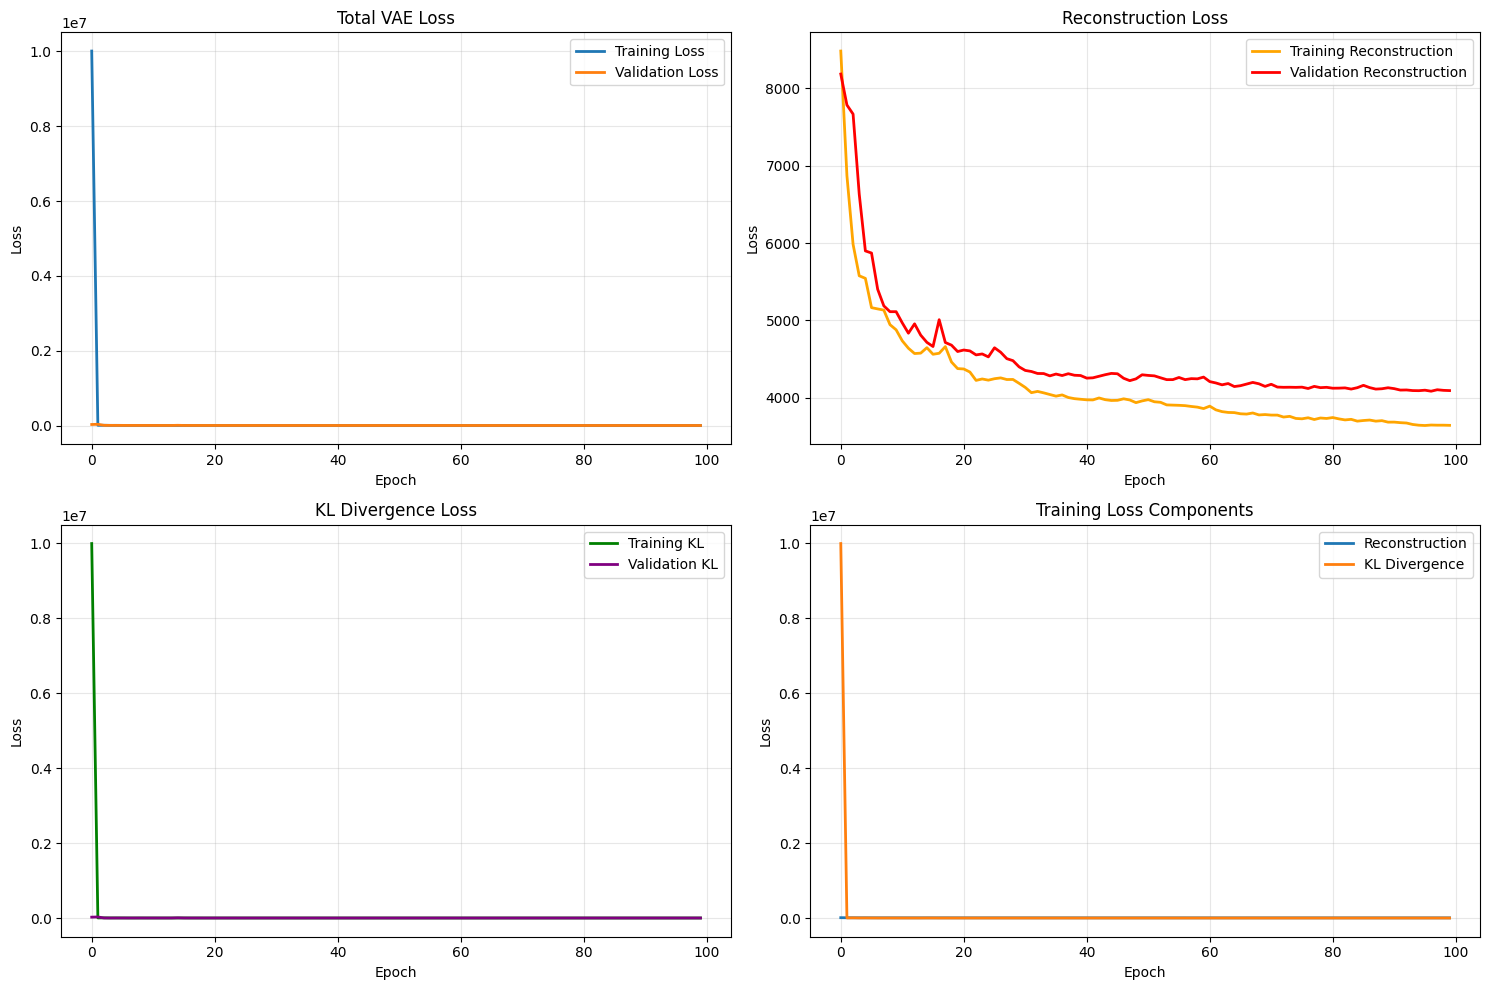


Visualizing reconstructions...


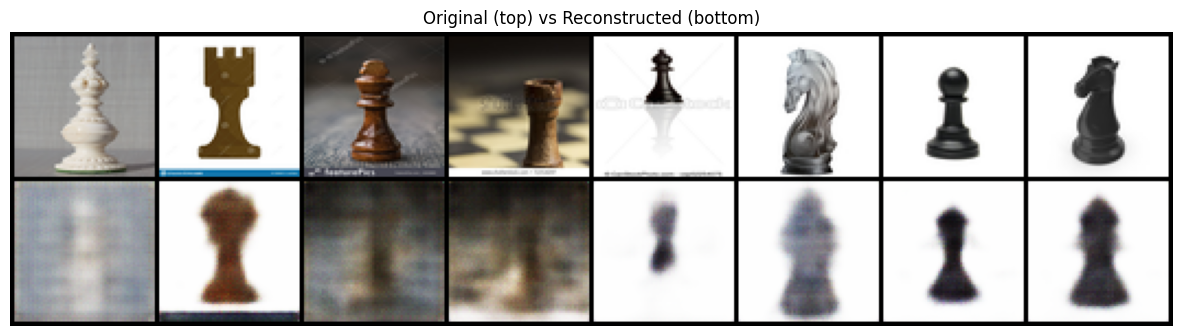


Generating new chess pieces...


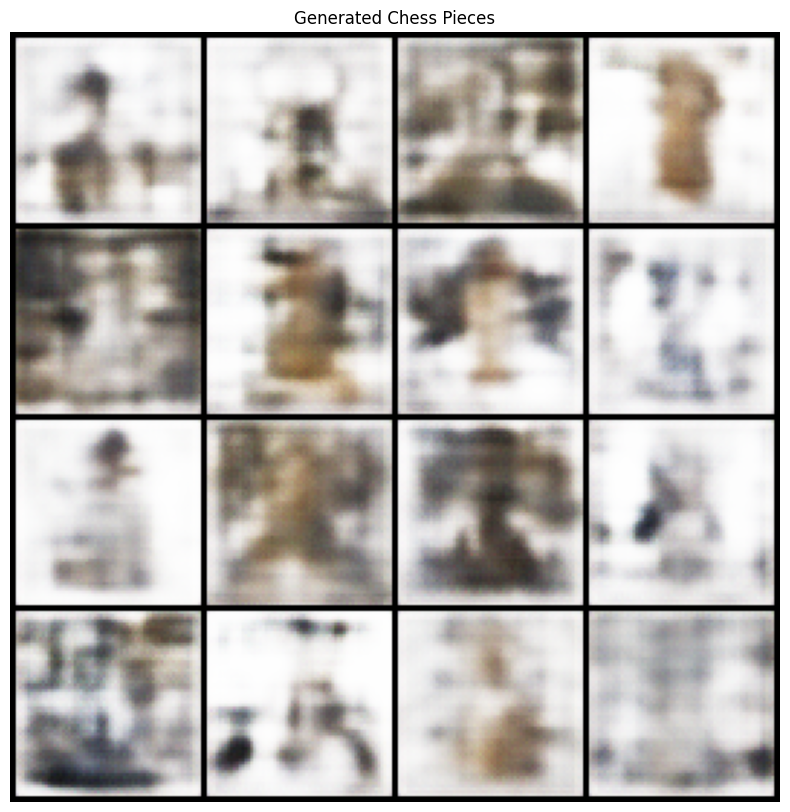


VAE TRAINING COMPLETED!
Best model saved as: best_chess_vae.pth
Final validation loss: 4219.9


In [35]:
# Step 5: Load best model and visualize
print("\n5. Loading best model and generating results...")
model.load_state_dict(torch.load('best_chess_vae.pth'))

# Plot training history
plot_vae_training_history(train_losses, val_losses, train_recon, train_kl, val_recon, val_kl)

# Visualize reconstructions
print("\nVisualizing reconstructions...")
visualize_reconstructions(model, val_loader, DEVICE, num_samples=8)

# Generate new samples
print("\nGenerating new chess pieces...")
generated_samples = generate_new_samples(model, DEVICE, num_samples=16)

print("\n" + "="*70)
print("VAE TRAINING COMPLETED!")
print(f"Best model saved as: best_chess_vae.pth")
print(f"Final validation loss: {min(val_losses):.1f}")
print("="*70)


## GAN

The GAN generates results that are clearly better than the VAE, but only nominally.

In [36]:
class Generator(nn.Module):
    """
    Generator network for chess piece GAN.
    Takes noise vector and generates 64x64 RGB images.
    """

    def __init__(self, noise_dim=100, output_channels=3, feature_maps=64):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim

        # Initial dense layer: noise_dim -> 4*4*512
        self.fc = nn.Linear(noise_dim, 4 * 4 * feature_maps * 8)

        # Transposed convolutions to upscale
        self.conv_layers = nn.Sequential(
            # 4x4x512 -> 8x8x256
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            # 8x8x256 -> 16x16x128
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            # 16x16x128 -> 32x32x64
            nn.ConvTranspose2d(feature_maps * 2, feature_maps,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # 32x32x64 -> 64x64x3
            nn.ConvTranspose2d(feature_maps, output_channels,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output in [-1, 1] range
        )

    def forward(self, noise):
        # noise shape: (batch_size, noise_dim)
        x = self.fc(noise)
        x = x.view(x.size(0), -1, 4, 4)  # Reshape to (batch, channels, 4, 4)
        x = self.conv_layers(x)
        return x

class Discriminator(nn.Module):
    """
    Discriminator network for chess piece GAN.
    Takes 64x64 RGB images and outputs real/fake probability.
    """

    def __init__(self, input_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            # 64x64x3 -> 32x32x64
            nn.Conv2d(input_channels, feature_maps,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32x64 -> 16x16x128
            nn.Conv2d(feature_maps, feature_maps * 2,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16x128 -> 8x8x256
            nn.Conv2d(feature_maps * 2, feature_maps * 4,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8x256 -> 4x4x512
            nn.Conv2d(feature_maps * 4, feature_maps * 8,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4x512 -> 1x1x1
            nn.Conv2d(feature_maps * 8, 1,
                     kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x.view(x.size(0), -1)  # Flatten to (batch_size, 1)


In [44]:
def get_gan_transforms(image_size=64):
    """Define transforms for GAN training."""

    # GAN typically uses [-1, 1] range for images (to match Tanh output)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] -> [-1,1]
    ])

    return transform

def create_gan_data_loader(df, batch_size=64, image_size=64):
    """Create data loader for GAN training (no train/val split needed)."""

    print(f"\nGAN Data preparation:")
    print(f"Total samples: {len(df)}")
    print(f"Batch size: {batch_size}")

    # Get transforms
    transform = get_gan_transforms(image_size)

    # Create dataset
    dataset = ChessDataset(df, transform=transform, return_labels=False)

    # Create data loader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                           num_workers=2, drop_last=True)  # drop_last for stable batch sizes

    return data_loader

In [38]:
def weights_init(m):
    """Initialize network weights (DCGAN convention)."""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def train_gan(generator, discriminator, data_loader, num_epochs=200,
              lr_g=0.0002, lr_d=0.0002, beta1=0.5, noise_dim=100, device='cuda'):
    """Train the GAN models."""

    # Move models to device
    generator.to(device)
    discriminator.to(device)

    # Initialize weights
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))

    # Training history
    g_losses = []
    d_losses = []
    d_x_history = []  # Discriminator output on real images
    d_g_z1_history = []  # Discriminator output on fake images (before D update)
    d_g_z2_history = []  # Discriminator output on fake images (after D update)

    # Fixed noise for consistent generation tracking
    fixed_noise = torch.randn(64, noise_dim, device=device)

    # Labels
    real_label = 1.0
    fake_label = 0.0

    print(f"\nStarting GAN training on {device}...")
    print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
    print("=" * 70)

    for epoch in range(num_epochs):
        for i, data in enumerate(data_loader):
            ############################
            # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
            ############################
            discriminator.zero_grad()

            # Train with real images
            real_images = data.to(device)
            batch_size = real_images.size(0)
            labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

            output = discriminator(real_images).view(-1)
            loss_d_real = criterion(output, labels)
            loss_d_real.backward()
            d_x = output.mean().item()

            # Train with fake images
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = generator(noise)
            labels.fill_(fake_label)

            output = discriminator(fake_images.detach()).view(-1)
            loss_d_fake = criterion(output, labels)
            loss_d_fake.backward()
            d_g_z1 = output.mean().item()

            loss_d = loss_d_real + loss_d_fake
            optimizer_D.step()

            ############################
            # (2) Update Generator: maximize log(D(G(z)))
            ############################
            generator.zero_grad()
            labels.fill_(real_label)  # Fake labels are real for generator cost

            output = discriminator(fake_images).view(-1)
            loss_g = criterion(output, labels)
            loss_g.backward()
            d_g_z2 = output.mean().item()

            optimizer_G.step()

            # Save losses
            g_losses.append(loss_g.item())
            d_losses.append(loss_d.item())
            d_x_history.append(d_x)
            d_g_z1_history.append(d_g_z1)
            d_g_z2_history.append(d_g_z2)

        # Print statistics
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'D Loss: {loss_d.item():.4f} | G Loss: {loss_g.item():.4f} | '
                  f'D(x): {d_x:.4f} | D(G(z)): {d_g_z1:.4f}/{d_g_z2:.4f}')

        # Save model checkpoints
        if epoch % 50 == 0 or epoch == num_epochs - 1:
            torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')

    print(f"\nGAN training completed!")
    return g_losses, d_losses, d_x_history, d_g_z1_history, d_g_z2_history, fixed_noise

In [39]:
def plot_gan_training_history(g_losses, d_losses, d_x, d_g_z1, d_g_z2):
    """Plot GAN training metrics."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Losses
    ax1.plot(g_losses, label='Generator Loss', linewidth=1, alpha=0.8)
    ax1.plot(d_losses, label='Discriminator Loss', linewidth=1, alpha=0.8)
    ax1.set_title('GAN Training Losses')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Smoothed losses (moving average)
    window = 100
    if len(g_losses) > window:
        g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
        d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
        ax2.plot(g_smooth, label='Generator (smoothed)', linewidth=2)
        ax2.plot(d_smooth, label='Discriminator (smoothed)', linewidth=2)
        ax2.set_title('Smoothed Training Losses')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Discriminator outputs
    ax3.plot(d_x, label='D(real)', linewidth=1, alpha=0.7)
    ax3.plot(d_g_z1, label='D(fake) before D update', linewidth=1, alpha=0.7)
    ax3.plot(d_g_z2, label='D(fake) after D update', linewidth=1, alpha=0.7)
    ax3.set_title('Discriminator Outputs')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Probability')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 1])

    # Training balance indicator
    iterations = range(len(g_losses))
    balance = np.array(g_losses) - np.array(d_losses)
    ax4.plot(balance, linewidth=1, alpha=0.8, color='purple')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Training Balance (G_loss - D_loss)')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Loss Difference')
    ax4.grid(True, alpha=0.3)
    ax4.text(0.02, 0.98, 'Positive: G struggling\nNegative: D struggling',
             transform=ax4.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

def generate_samples(generator, noise_dim=100, num_samples=16, device='cuda'):
    """Generate new chess piece samples."""

    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim, device=device)
        fake_images = generator(noise)

        # Denormalize from [-1,1] to [0,1] for display
        fake_images = (fake_images + 1) / 2

        # Create grid
        grid = make_grid(fake_images, nrow=4, padding=2, normalize=False)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title('Generated Chess Pieces (GAN)')
        plt.axis('off')
        plt.show()

        return fake_images

def show_training_progress(generator, fixed_noise, device, epoch):
    """Show generator progress during training."""

    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        fake_images = (fake_images + 1) / 2  # Denormalize

        # Save grid of images
        grid = make_grid(fake_images[:16], nrow=4, padding=2, normalize=False)
        save_image(grid, f'generated_samples_epoch_{epoch}.png')

def compare_real_vs_fake(generator, data_loader, noise_dim=100, device='cuda'):
    """Compare real images with generated ones."""

    # Get real images
    real_images = next(iter(data_loader))[:8].to(device)
    real_images = (real_images + 1) / 2  # Denormalize for display

    # Generate fake images
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(8, noise_dim, device=device)
        fake_images = generator(noise)
        fake_images = (fake_images + 1) / 2  # Denormalize

    # Combine real and fake
    comparison = torch.cat([real_images, fake_images])

    # Create grid
    grid = make_grid(comparison, nrow=8, padding=2, normalize=False)

    # Plot
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.cpu().permute(1, 2, 0))
    plt.title('Real Chess Pieces (top) vs Generated (bottom)')
    plt.axis('off')
    plt.show()


In [49]:
CHESS_FOLDER = "drive/MyDrive/Chess"  # Path to your chess pieces folder
BATCH_SIZE = 64
NUM_EPOCHS = 200
LR_G = 0.0002  # Generator learning rate
LR_D = 0.0002  # Discriminator learning rate
BETA1 = 0.5    # Adam optimizer beta1
NOISE_DIM = 100
IMAGE_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load data (reuse VAE data loader)
print("\n1. Loading chess dataset...")
df, piece_names = load_dataset(CHESS_FOLDER, target_size=(IMAGE_SIZE, IMAGE_SIZE))

# Step 2: Create data loader (no train/val split for GAN)
print("\n2. Creating GAN data loader...")
data_loader = create_gan_data_loader(df, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)


1. Loading chess dataset...
Found 6 folders
Processing:
  Bishop: 73 images
  King: 61 images
  Knight: 95 images
  Pawn: 88 images
  Queen: 68 images
  Rook: 90 images

Dataset loaded successfully!
Total images: 475
Unique classes: 6
Image shape: (64, 64, 3)

2. Creating GAN data loader...

GAN Data preparation:
Total samples: 475
Batch size: 64


In [50]:
# Step 3: Create models
print("\n3. Creating GAN models...")
generator = Generator(noise_dim=NOISE_DIM, output_channels=3)
discriminator = Discriminator(input_channels=3)

print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

# Step 4: Train GAN
print("\n4. Training GAN...")
g_losses, d_losses, d_x, d_g_z1, d_g_z2, fixed_noise = train_gan(
  generator, discriminator, data_loader,
  num_epochs=NUM_EPOCHS,
  lr_g=LR_G,
  lr_d=LR_D,
  beta1=BETA1,
  noise_dim=NOISE_DIM,
  device=DEVICE
  )

# Step 5: Visualize results
print("\n5. Visualizing results...")

# Load final models
generator.load_state_dict(torch.load(f'generator_epoch_{NUM_EPOCHS-1}.pth'))
discriminator.load_state_dict(torch.load(f'discriminator_epoch_{NUM_EPOCHS-1}.pth'))


3. Creating GAN models...
Generator parameters: 3,583,872
Discriminator parameters: 2,765,568

4. Training GAN...

Starting GAN training on cuda...
Generator parameters: 3,583,872
Discriminator parameters: 2,765,568
Epoch [  1/200] | D Loss: 0.2928 | G Loss: 5.6487 | D(x): 0.8922 | D(G(z)): 0.1089/0.0049
Epoch [ 11/200] | D Loss: 1.6045 | G Loss: 3.0651 | D(x): 0.3509 | D(G(z)): 0.0012/0.1332
Epoch [ 21/200] | D Loss: 0.1303 | G Loss: 4.6116 | D(x): 0.9248 | D(G(z)): 0.0413/0.0159
Epoch [ 31/200] | D Loss: 0.3231 | G Loss: 4.2101 | D(x): 0.9509 | D(G(z)): 0.2164/0.0240
Epoch [ 41/200] | D Loss: 2.3527 | G Loss: 11.7563 | D(x): 0.9706 | D(G(z)): 0.8244/0.0005
Epoch [ 51/200] | D Loss: 0.2856 | G Loss: 3.3670 | D(x): 0.8464 | D(G(z)): 0.0376/0.0970
Epoch [ 61/200] | D Loss: 0.7403 | G Loss: 2.7963 | D(x): 0.7729 | D(G(z)): 0.1808/0.2798
Epoch [ 71/200] | D Loss: 0.0908 | G Loss: 4.3452 | D(x): 0.9400 | D(G(z)): 0.0262/0.0228
Epoch [ 81/200] | D Loss: 0.6345 | G Loss: 5.4784 | D(x): 0.97

<All keys matched successfully>

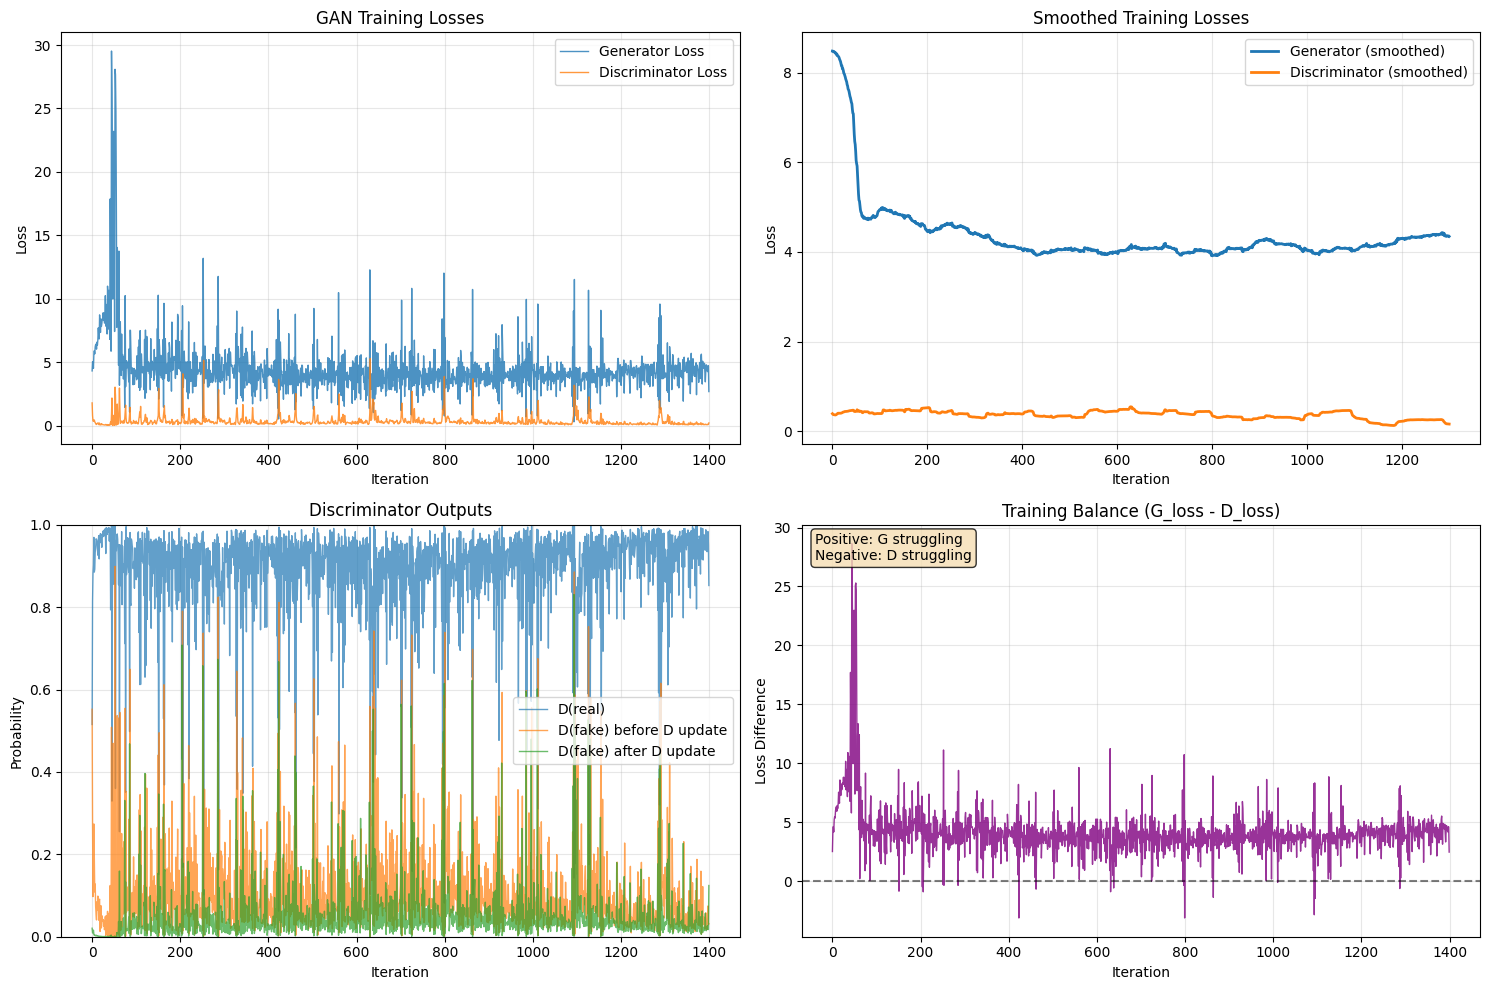


Generating new chess pieces...


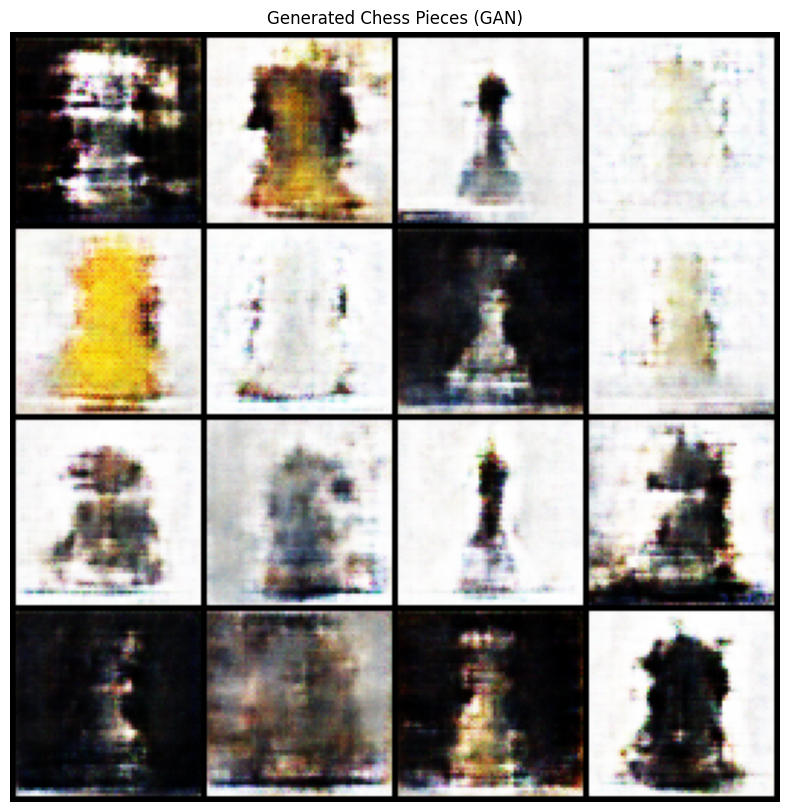


Comparing real vs generated...


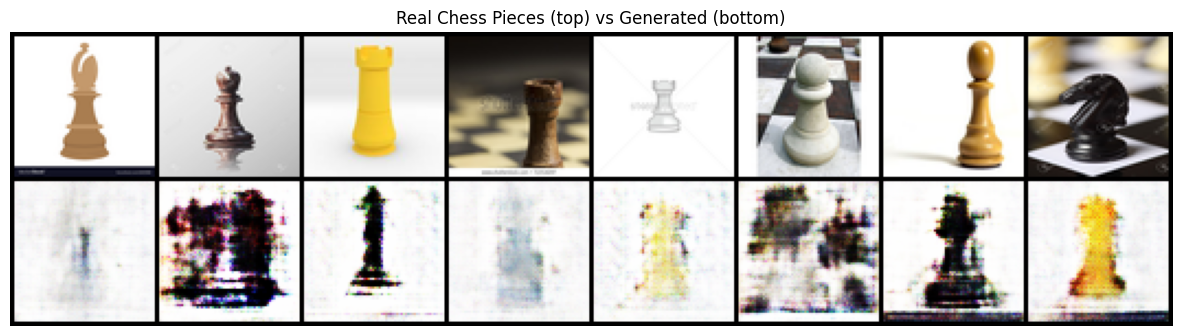


GAN TRAINING COMPLETED!
Final models saved as: generator_epoch_199.pth, discriminator_epoch_199.pth
Generated samples can be found in generated_samples_epoch_*.png files


In [51]:
# Plot training history
plot_gan_training_history(g_losses, d_losses, d_x, d_g_z1, d_g_z2)

# Generate new samples
print("\nGenerating new chess pieces...")
generated_samples = generate_samples(generator, NOISE_DIM, 16, DEVICE)

# Compare real vs fake
print("\nComparing real vs generated...")
compare_real_vs_fake(generator, data_loader, NOISE_DIM, DEVICE)

print("\n" + "="*70)
print("GAN TRAINING COMPLETED!")
print(f"Final models saved as: generator_epoch_{NUM_EPOCHS-1}.pth, discriminator_epoch_{NUM_EPOCHS-1}.pth")
print(f"Generated samples can be found in generated_samples_epoch_*.png files")
print("="*70)